## TO DO
* Are the flux errors propagated correctly like this? Is this reasonable?
* Plot mags and flux in a subplot maybe to see ^
* Refine plot
* Generalize in a function so that it may be iterated over all data
* Gaussian rise exp-decay fitting aan +/- 200 dagen rond de peak: g-band and r-band samen, met fixed color
* Bayesian blocks

## Questions
* Mean chi acceptance? -> no, just multiply all errors by $\sqrt{\chi^2}$.
* Are the flux errors propagated correctly like this? Is this reasonable? ADU -> muJy or ADU -> mag -> muJy? About mags - mag2flux is absolute magnitude, but aren't measurements relative? -> no, see picture Flux in jansky door mag2flux(zeropoint) * flux counts, error schaalt met mag2flux(zeropoint) 

* Confident/unconfident markings? -> skip

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm

In [3]:
PATH = os.getcwd()
DATAPATH = os.path.join(PATH,'100Random_Lightcurves')
columns = ['sindex', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime', 'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr', 'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend', 'procstatus']
dtypes = [(columns[x],float) for x in range(len(columns))]
dtypes[4] = ('filter',r'U8')

In [4]:
test_lc = pd.DataFrame(np.genfromtxt(os.path.join(DATAPATH,os.listdir(DATAPATH)[0]),skip_header=53,dtype=dtypes))
test_lc

,sindex,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,...,forcediffimsnrap,aperturecorr,dnearestrefsrc,nearestrefmag,nearestrefmagunc,nearestrefchi,nearestrefsharp,refjdstart,refjdend,procstatus
0,0.0,580.0,15.0,4.0,ZTF_r,5.491771e+11,0.0,2.8748,148.8040,6.42654,...,1.878332,1.217380,0.313384,16.596,0.061,5.253,0.394,2.458161e+06,2.458223e+06,0.0
1,1.0,580.0,15.0,4.0,ZTF_g,5.491972e+11,0.0,2.0825,80.8191,4.35943,...,-3.158954,1.047711,0.165528,17.582,0.052,4.383,0.209,2.458167e+06,2.458304e+06,0.0
2,2.0,580.0,15.0,4.0,ZTF_r,5.521723e+11,0.0,2.4115,134.1240,7.77843,...,2.636503,1.049092,0.313384,16.596,0.061,5.253,0.394,2.458161e+06,2.458223e+06,0.0
3,3.0,580.0,15.0,4.0,ZTF_g,5.522161e+11,0.0,2.4980,72.2306,4.30117,...,-2.010171,1.065764,0.165528,17.582,0.052,4.383,0.209,2.458167e+06,2.458304e+06,0.0
4,4.0,580.0,15.0,4.0,ZTF_i,5.541706e+11,0.0,2.1897,31.7959,9.06504,...,3.751798,1.046463,0.176935,16.320,0.059,4.458,0.308,2.458174e+06,2.458321e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,1093.0,580.0,15.0,4.0,ZTF_g,2.398222e+12,0.0,1.9564,85.4933,10.76900,...,-0.375785,1.060575,0.165528,17.582,0.052,4.383,0.209,2.458167e+06,2.458304e+06,0.0
1094,1094.0,580.0,15.0,4.0,ZTF_g,2.408227e+12,0.0,2.2255,83.7407,7.85944,...,4.212150,1.064293,0.165528,17.582,0.052,4.383,0.209,2.458167e+06,2.458304e+06,0.0
1095,1095.0,580.0,15.0,4.0,ZTF_g,2.411239e+12,0.0,2.0925,69.5741,8.60349,...,2.771303,1.051333,0.165528,17.582,0.052,4.383,0.209,2.458167e+06,2.458304e+06,0.0
1096,1096.0,580.0,15.0,4.0,ZTF_g,2.417209e+12,0.0,2.5967,77.0608,7.81071,...,2.540344,1.070151,0.165528,17.582,0.052,4.383,0.209,2.458167e+06,2.458304e+06,0.0


In [5]:
"""Define the quality cuts."""
def q_cuts(ZTF, softcuts=True,output=False):
    '''
    update for Jul 2023
    main difference:  forcediffimfluxap/forcediffimflux less strict
    '''
    
    DC2Jy = sjoert.stellar.mag2flux(ZTF['zpdiff'])

    app_flux_ratio = ZTF['forcediffimfluxap'] / ZTF['forcediffimflux']
    app_psf_diff = (ZTF['forcediffimfluxap'] - ZTF['forcediffimflux']) #/ np.abs(ZTF['forcediffimfluxap'])

    #(np.abs(np.log10(app_flux_ratio)) <1.5) *\

    #final three masks added by Tim from section 6.1 of "A New Forced Photometry Service for the Zwicky Transient Facility" 
    iok =   (ZTF['procstatus'] != '56') * \
            (ZTF['scisigpix'] < 20) * \
            (ZTF['sciinpseeing'] < 4.0) * \
            (ZTF['zpmaginpscirms'] < 0.05)  * \
            (ZTF['infobitssci'] < 33554432) * \
            (ZTF['scisigpix'] <= 25) * \
            (ZTF['sciinpseeing'] <= 4) * \
            (ZTF['procstatus'] == 0) #this one added by Tim because error code should be 0 for an epoch, else there will probably still be a faulty epoch in there.
                
          
    if softcuts==False: 
        iok *=  (ZTF['adpctdif1'] < 0.2)  *\
                (np.abs(app_psf_diff)<200)*\
                (DC2Jy*ZTF['forcediffimflux'] > -50e-6) *\
                (DC2Jy*np.abs(ZTF['forcediffimfluxunc']) < 30e-6)    

    # new in 2022 check for zero-point outliers, per filter
    for flt in np.unique(ZTF['filter']):
        iflt = ZTF['filter']==flt

        if softcuts:
            iok.loc[iflt] *= np.abs(np.log10(DC2Jy.loc[iflt]/np.median(DC2Jy.loc[iflt])))<0.4 
        else:
            iok.loc[iflt] *= np.abs(np.log10(DC2Jy.loc[iflt]/np.median(DC2Jy.loc[iflt])))<0.1 # new 2023 (was 0.4)
    if output:
        # hack for checking cuts
        plt.hist(app_psf_diff,range=[-300,300],bins=30)
        plt.pause(0.1)
        # key = input()

        print ('# of raw points     :', len(ZTF))    
        print ('# of points rejected:', len(ZTF)-sum(iok))

    return iok

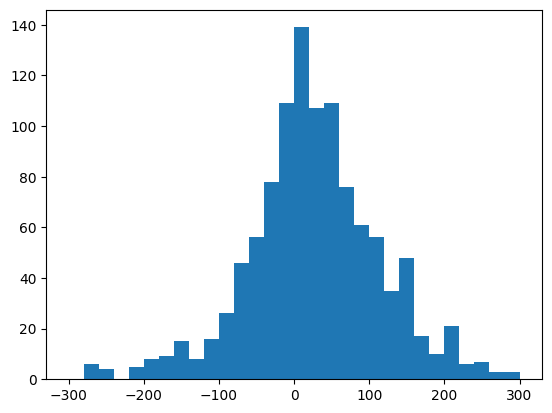

# of raw points     : 1098
# of points rejected: 183


0        True
1        True
2        True
3        True
4       False
        ...  
1093     True
1094     True
1095     True
1096     True
1097     True
Length: 1098, dtype: bool

In [6]:
q_cuts(test_lc,output=True)

In [7]:
def field_check(ZTF,output=False):
    fields,counts = np.unique(ZTF['field'],return_counts=True)
    imax = np.argmax(counts)
    if output:
        print(f"Field {fields[imax]} occurs most with {counts[imax]} / {len(ZTF)} instances.")

    to_keep = ZTF['field'] == fields[imax]

    return to_keep

def filter_split(ZTF,asmasks=False):
    filters = np.unique(ZTF['filter'])
    if asmasks:
        return {x:(ZTF['filter'] == x) for x in filters}
    
    return {x:ZTF[(ZTF['filter'] == x)] for x in filters}


1.080946338983051


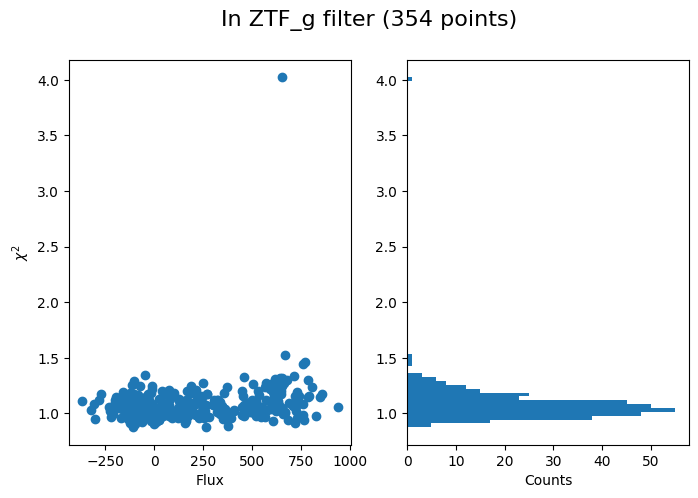

1.1775209421841542


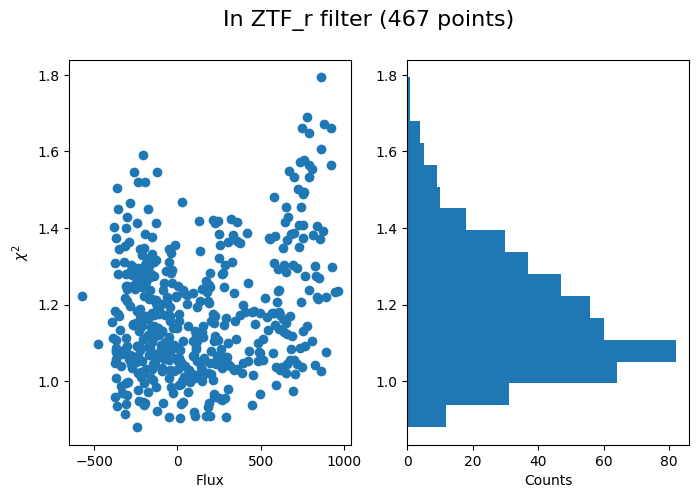

1.1199235425531913


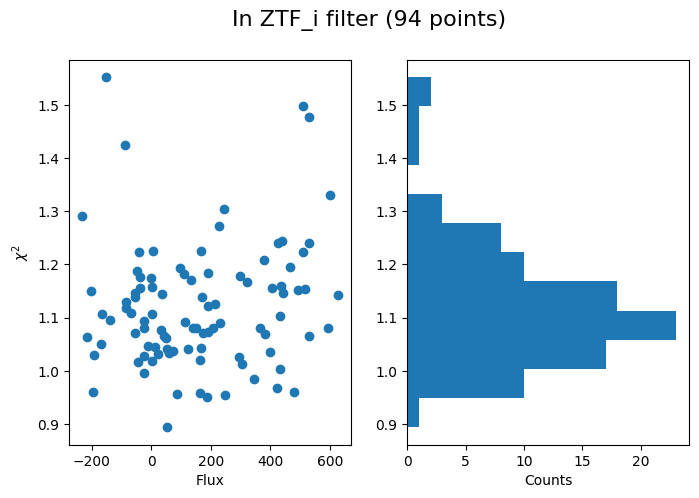

In [8]:
def flux_unc_val(ZTF,acceptance=0.1,output=False):
    chisq = ZTF['forcediffimchisq']
    mean_chi = np.mean(chisq)

    # if not 1 - acceptance < mean_chi < 1 + acceptance:
    #     ZTF['forcediffimfluxunc'] *= np.sqrt(mean_chi)
    if output:
        print(mean_chi)

        fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(8,5))
        plt.suptitle(f"In {ZTF['filter'].iloc[0]} filter ({len(ZTF)} points)",fontsize=16)
        ax1.set_ylabel(r"$\chi^2$")
        ax1.set_xlabel("Flux")
        ax2.set_xlabel("Counts")
        ax1.scatter(ZTF['forcediffimflux'],chisq)
        ax2.hist(chisq,bins='auto',orientation='horizontal')
        plt.show()

iok = q_cuts(test_lc) * field_check(test_lc)
test_lc = test_lc[iok]
filter_dict = filter_split(test_lc)
#in case there is no g, r or i filter in the data the code doesn't break
filter_data_list = []
#in case there is no g, r or i filter in the data the code doesn't break
try:
    filter_data_list.append(filter_dict['ZTF_g'])
    filter_data_list.append(filter_dict['ZTF_r'])
    filter_data_list.append(filter_dict['ZTF_i'])
except:
    KeyError

for val in filter_data_list:
    flux_unc_val(val,output=True)

In [9]:
def get_mags(ZTF,SNT=3,SNU=5):
    if ( ZTF['forcediffimflux'] / ZTF['forcediffimfluxunc'] ) > SNT:
        # We have a "confident" detection; compute and plot mag with error bar:
        mag = ZTF['zpdiff'] - 2.5 * np.log10( ZTF['forcediffimflux'] )
        sigma_mag = 1.0857 * ZTF['forcediffimfluxunc'] / ZTF['forcediffimflux']
        return mag,sigma_mag
    else:
        # Compute flux upper limit and plot as arrow or triangle:
        mag = ZTF['zpdiff'] - 2.5 * np.log10( SNU * ZTF['forcediffimfluxunc'] )
        return mag,0
        
def sig_m2sig_f(mag,sigma_mag):
    return np.log(10)*0.4*mag*10**(-0.4*(mag+48.6)) * 1e23 * sigma_mag

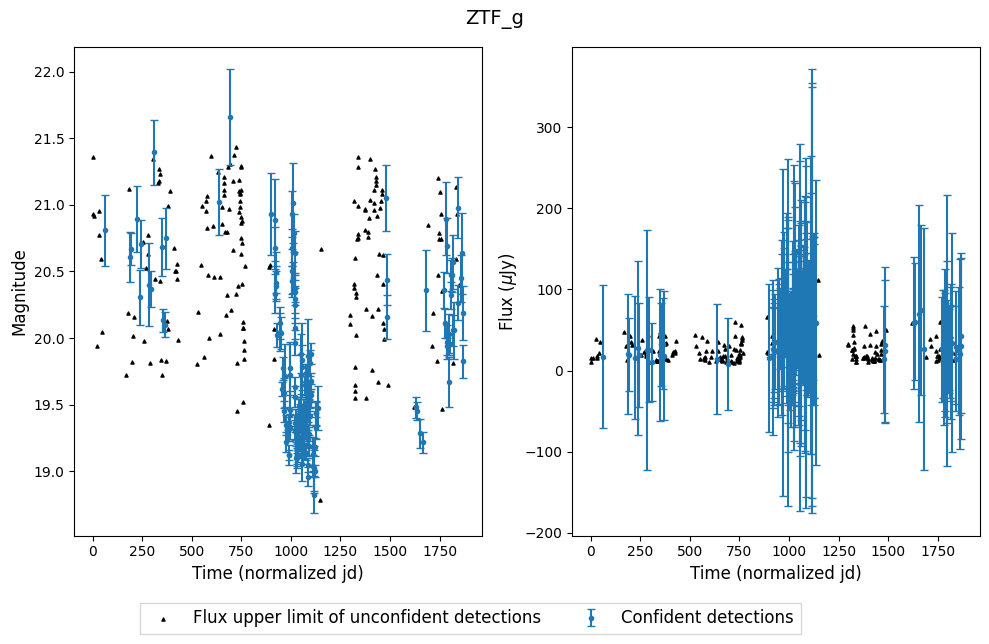

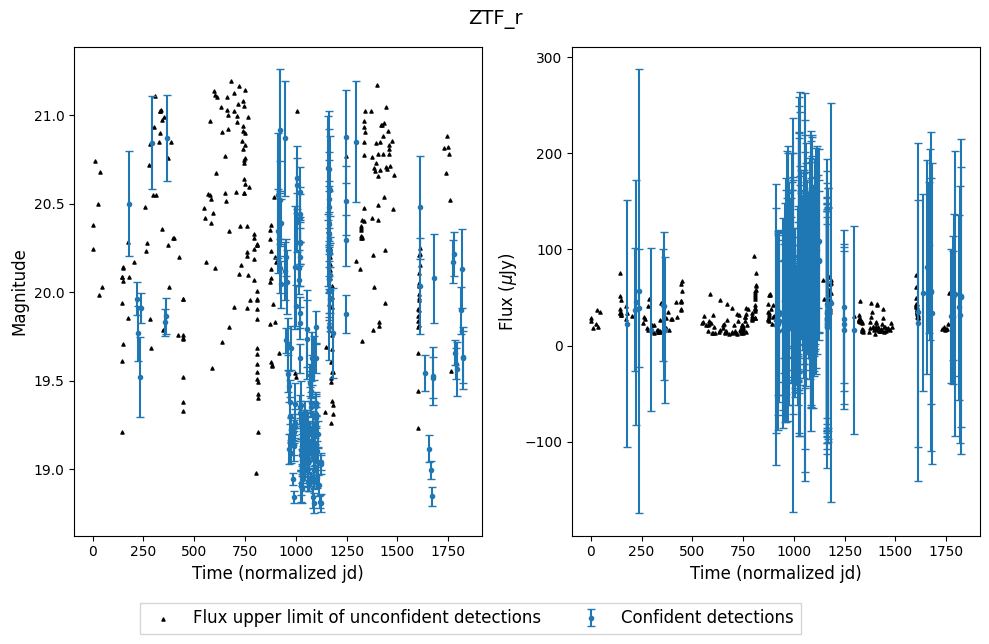

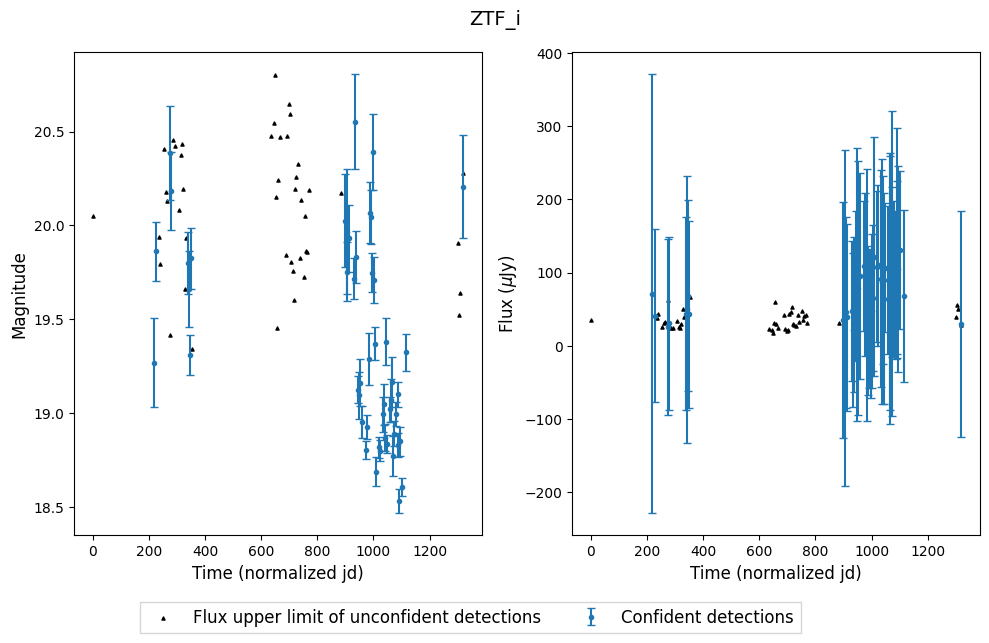

In [10]:
for f in filter_data_list:
    times = np.array(f['jd'] - f['jd'].iloc[0])
    mags,errs = [],[]
    bad_indices,no_err_mags = [],[]
    f.reset_index(inplace=True,drop=True)
    for i,epoch in f.iterrows():
        mag,err = get_mags(epoch)
        if err == 0:
            bad_indices.append(i)
            no_err_mags.append(mag)
        else:
            mags.append(mag)
            errs.append(err)

    mags = np.array(mags)
    errs = np.array(errs)
    no_err_mags = np.array(no_err_mags)

    bad_times = times[bad_indices]
    times = np.delete(times,bad_indices)
    
    fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(10,6))
    plt.suptitle(f['filter'].iloc[0],fontsize=14)
    ax1.errorbar(times,mags,errs,xerr=None,fmt='.',capsize=3)
    ax1.scatter(bad_times,no_err_mags,s=5,marker='^',c='black')
    ax2.errorbar(times,sjoert.stellar.mag2flux(mags)*1e6,sig_m2sig_f(mags,errs)*1e6,xerr=None,fmt='.',capsize=3,label='Confident detections')
    ax2.scatter(bad_times,sjoert.stellar.mag2flux(no_err_mags)*1e6,marker='^',c='black',s=5,label='Flux upper limit of unconfident detections')

    ax1.set_ylabel("Magnitude",fontsize=12)
    ax2.set_ylabel(r"Flux ($\mu$Jy)",fontsize=12)
    ax1.set_xlabel("Time (normalized jd)",fontsize=12)
    ax2.set_xlabel("Time (normalized jd)",fontsize=12)

    plt.tight_layout()
    ax2.legend(loc='upper center', bbox_to_anchor=(-0.25, -0.12),fancybox=False, shadow=False, ncol=2,fontsize=12)
    plt.show()


In [14]:

for filename in os.listdir(DATAPATH):
    print(filename)
    lcpath = os.path.join(DATAPATH,filename)
    data = pd.DataFrame(np.genfromtxt(lcpath,skip_header=53,dtype=dtypes))
    iok = q_cuts(data) * field_check(data)
    data = data[iok]
    filter_dict = filter_split(data)
    filter_data_list = []
    #in case there is no g, r or i filter in the data the code doesn't break
    try:
        filter_data_list.append(filter_dict['ZTF_g'])
        filter_data_list.append(filter_dict['ZTF_r'])
        filter_data_list.append(filter_dict['ZTF_i'])
    except:
        KeyError
        
    for i,f in enumerate(filter_data_list):
        print(f"Median chi-square for filter {list(filter_dict.keys())[i]} is {np.median(f['forcediffimchisq'])}")

    for i,f in enumerate(filter_data_list):
        times = f['jd'] - f['jd'].iloc[0]
        # plt.figure()
        # plt.suptitle(f"Filter {list(filter_dict.keys())[i]}")
        mags,errs = [],[]
        for i,epoch in f.iterrows():
            mag,err = get_mags(epoch)
            mags.append(mag)
            errs.append(err)

        # plt.errorbar(times,mags,errs,xerr=None,fmt='.',capsize=3)
        # plt.errorbar(times,sjoert.stellar.mag2flux(np.array(mags))*1e6,sig_m2sig_f(np.array(mags),np.array(errs))*1e6,xerr=None,fmt='.',capsize=3)
        # plt.scatter(times,sjoert.stellar.mag2flux(np.array(mags))*1e6,s=10)
        # plt.show()
    print('--'*30)



batchfp_req0000317596_lc.txt
Median chi-square for filter ZTF_g is 1.0549054999999998
Median chi-square for filter ZTF_i is 1.147336
Median chi-square for filter ZTF_r is 1.099834
------------------------------------------------------------
batchfp_req0000317597_lc.txt
Median chi-square for filter ZTF_g is 1.259888
Median chi-square for filter ZTF_r is 1.4574155000000002
------------------------------------------------------------
batchfp_req0000317598_lc.txt
Median chi-square for filter ZTF_g is 0.9883385
Median chi-square for filter ZTF_r is 1.012709
------------------------------------------------------------
batchfp_req0000317599_lc.txt
Median chi-square for filter ZTF_g is 0.969038
Median chi-square for filter ZTF_i is 0.987362
Median chi-square for filter ZTF_r is 0.9896
------------------------------------------------------------
batchfp_req0000317600_lc.txt
Median chi-square for filter ZTF_g is 0.970568
Median chi-square for filter ZTF_i is 0.976291
Median chi-square for filter